# DECISION TREE FOR FOOD 101
# EXTRACTING FEATURES WITH THE THESE METHODS TO BUILD THE MODEL:
# 1.  HISTOGRAM OF ORIENTED GRADIENTS;HOG >>>> (Shape Features)
# 2.  COLOR HISTOGRAM EXTRACTION >>>>> (Color-based Features)
# 3.  EFFICIENT NET DEEP EXTRACTED FEATURES USING THE OUTPUT OF THE LAYERS
#     (TRANSFER LEARNING OF LEARNED FEATURES FROM PRE TRAINED CNNs)


# Food Image Classification for Nutritional Estimation
# TEST 7 using SCIKIT_LEARN & Efficient NET
# *********************
## Since Histogram of Oriented Gradients (HOG) and Color Hisotogram Features gave the best resukts so far, This new model aims to perform better with deep features extracted by a CNN.
# *********************
## EfficientNet Features capture deep hierarchical patterns in images
## HOG & Color Histogram provide local shape texture & color information.
# *********************
## TRANSFER LEARNING
## Extract Deep Features: Remove the top classification layer from EfficientNet and use the output of the penultimate layer as features.

# IMPORTING LIBRARIES

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from skimage.feature import hog
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model


# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


# LOAD FOOD101 TENSORFLOW DATASET & PRINT FIRST 10 FOOD CLASSES

In [3]:
# Load Food-101 dataset
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

class_names = info.features["label"].names[:10]
# Get the first 10 class names

# Print information about the dataset
print("First 10 classes:", class_names)
# Print class names of the first 10 classes for confirmation


First 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


# FUCNTION TO FILTER FOOD101 TO MATCH FIRST 10 CLASS NAMES SELECTED

In [4]:
# Measure training time for runtime performance
start_time = time.time()

# Function to filter dataset to only the first 10 classes

def filter_classes(image, label):
  # paremter image and label for labeling each food image class

    return label < 10
    # Keep only images where label is between 0 and 9 (first 10 classes)

# Apply filter to remove unwanted classes in FOOD 101 dataset
filtered_dataset = dataset.filter(filter_classes)

# Count dataset size to ensure same size across. SUM of all 1s
dataset_size = sum(1 for _ in filtered_dataset)

# print total images in filtered dataset
print(f"Total images in first 10 classes: {dataset_size}")

Total images in first 10 classes: 7500


# DISPLAY ONE  IMAGE PER UNIQUE FOOD CLASS

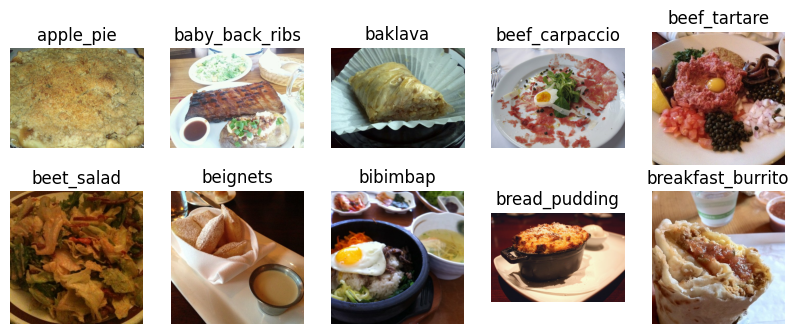

In [5]:
# Dictionary to store one image per class
class_images = {}

# for loop to iterate through filtered 10 classes dataset
for image, label in filtered_dataset:
  # for each image and class label

    label_value = label.numpy()
    # for converting the tensorflow tensor label to python numpy integer
    # integer is need for the indexing in teh dictionary

    # interating through the dictionary storing the first images for each unique food classs label
    if label_value not in class_images:
    # if the integer as the label is not in the dictionary

        class_images[label_value] = image
        # aasign an image from the dataset corresponding uniquely to the dictionary stored food class labels

    if len(class_images) == 10:
    # Stop when we have one image per class coreresponding to each food class
        break

# Plot images
plt.figure(figsize=(10, 10))
# creating a new figure with 10 inches width and height

# iteraing over each key- value pair (class label and an image)
for i, (label, image) in enumerate(sorted(class_images.items())):
    # sorting the items in order and enumerating

    plt.subplot(5, 5, i + 1)
    # subplot in figure for 5 rows and 5 columns

    plt.imshow(image.numpy())
    # displays the image subplot
    # converting the tensorflow tensor image to python numpy integer for matplotlib

    plt.title(class_names[label])
    # sets the title of each plot to the label of each class name

    plt.axis("off")
    # removes axis ticks

plt.show()
# displays complete figure

# DATASET PREPARATION: Split into Train & Validation Sets

In [6]:
# Define train-validation split (80-20)
train_split = 0.8
# 80% for training

train_size = int(train_split * dataset_size)
# the defined split 0.8 multiplied by the dataset size, ensured to return integer and stored in train_size variable

# Split the dataset
# train set
train_ds = filtered_dataset.take(train_size)
# take () method extracts the train_size from the filtered dataset, 80% of filtered dataset

# validation set
val_ds = filtered_dataset.skip(train_size)
# skip () method ignores the train_size from the filtered dataset, remaining 20% of filtered dataset used for validation
# remaining 20% sample from dataset

print(f"Training set size: {train_size}")
print(f"Validation set size: {dataset_size - train_size}")

Training set size: 6000
Validation set size: 1500


# DATASET PREPROCESSING: Resizing image and normalisation
# >>> To pass into the efficientNET model to improve performance

In [7]:
def preprocess(image, label):

    """Preprocess function to resize image and normalize it for EfficientNet"""
    image = tf.image.resize(image, (224, 224))  # Resize to EfficientNet input size
    image = preprocess_input(image)  # EfficientNet preprocessing

    return image, label

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess).batch(32)
val_ds = val_ds.map(preprocess).batch(32)

# Checking Image Shapes

In [8]:
# Check the shape of images
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("First image shape:", images[0].shape)
    print("Image data type:", images.dtype)
    print("First few pixel values:", images[0,0,0:5])

Image batch shape: (32, 224, 224, 3)
First image shape: (224, 224, 3)
Image data type: <dtype: 'float32'>
First few pixel values: tf.Tensor(
[[85.22959  27.229591 23.229591]
 [88.85715  29.857143 23.857143]
 [91.78571  32.785713 26.785713]
 [88.60714  32.607143 26.607143]
 [76.36224  27.933674 23.29082 ]], shape=(5, 3), dtype=float32)


# LOAD DECISION TREE MODEL AND EFFICIENT NET MODEL

In [9]:
# Create and train decision tree
dt_classifier = DecisionTreeClassifier(random_state=42)

# Load EfficientNet without top classification layer
base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling='avg')
efficientnet_extractor = Model(inputs=base_model.input, outputs=base_model.output)

print ('decision tree and efficientNET model loaded.')

decision tree and efficientNET model loaded.


# Extract EfficientNet model Features

In [10]:
def extract_efficientnet_features(dataset):
    features, labels = [], []

    for batch_images, batch_labels in dataset:
        batch_images = batch_images.numpy()  # Convert Tensor to NumPy
        batch_images = preprocess_input(batch_images)  # EfficientNet preprocessing

        batch_features = efficientnet_extractor.predict(batch_images)  # Extract deep features
        features.append(batch_features)
        labels.append(batch_labels.numpy())

    return np.vstack(features), np.concatenate(labels)

# Extract EfficientNet features
X_train_eff, y_train = extract_efficientnet_features(train_ds)
X_val_eff, y_val = extract_efficientnet_features(val_ds)

print(" EfficientNet model features have been extracted.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━

# Extract Histogram of Oriented Gradients (HOG) and Color Hisotogram Features

In [11]:
def extract_combined_features(dataset):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        batch_images = batch_images.numpy()
        batch_labels = batch_labels.numpy()

        for i in range(len(batch_images)):
            img = batch_images[i]

            # ------------------
            # Color Histogram Extraction:
            # For each channel, we compute a histogram with 8 bins over the range [0,1]
            r_hist = np.histogram(img[:, :, 0], bins=8, range=(0, 1))[0]
            g_hist = np.histogram(img[:, :, 1], bins=8, range=(0, 1))[0]
            b_hist = np.histogram(img[:, :, 2], bins=8, range=(0, 1))[0]
            color_features = np.concatenate([r_hist, g_hist, b_hist])

            # ------------------
            # HOG Feature Extraction:
            # Convert to grayscale using a standard luminance conversion.
            gray = np.dot(img, [0.2989, 0.5870, 0.1140])
            hog_features = hog(gray,
                               pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2),
                               feature_vector=True)

            # Combine the features: note that color and HOG features are quite different:
            # - Color features focus on overall color distribution.
            # - HOG features capture local edge and gradient structures.
            combined_features = np.concatenate([color_features, hog_features])

            features.append(combined_features)
            labels.append(batch_labels[i])

    return np.array(features), np.array(labels)


    # Extract HOG & Color Histogram features
X_train_hog, y_train = extract_combined_features(train_ds)
X_val_hog, y_val = extract_combined_features(val_ds)

print("HOG and Histogram of Colors features have been extracted.")

HOG and Histogram of Colors features have been extracted.


# Combine Both Extracted Features: Better representation of features.

In [161]:
# Concatenate EfficientNet and handcrafted features
X_train_combined = np.hstack([X_train_eff, X_train_hog])
X_val_combined = np.hstack([X_val_eff, X_val_hog])

print("Efficient Net Features, HOG and Histogram of Colors have been extracted and merged into a single feature vector.")

Efficient Net Features, HOG and Histogram of Colors have been extracted and merged into a single feature vector.


# Normalising and Standardising Features from EfficientNet deep abstract features

In [162]:
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)

# Optional PCA for feature vector dimension reduction (Model Testing)

In [169]:
apply_pca = True  # Set to False if you want to use raw features

if apply_pca:
    pca = PCA(n_components=50)  # 15 has been a good one dimension for most models so far
    X_train_combined = pca.fit_transform(X_train_combined)
    X_val_combined = pca.transform(X_val_combined)
    print("PCA applied to combined features.")
    print("Feature vector size after PCA:", X_train_combined.shape[1])
elif not apply_pca:
    print("Using raw features without PCA.")
    print("Feature vector size without PCA:", X_train_combined.shape[1])

PCA applied to combined features.
Feature vector size after PCA: 50


# Hyperparameter Optimisation for Decision Trees GridSearch CV


In [170]:
# Decision Tree Hyperparameters
# We'll use GridSearchCV to try different hyperparameters for the Decision Tree

# param_grid = {
    # 'max_depth': [5, 10, 15],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
# }


# Decision Tree Hyperparameters 2
# To reduce overfitting of models

param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 20, 30],  # Higher values reduce overfitting
    'min_samples_leaf': [5, 10, 20],  # Increase min_samples_leaf
    'ccp_alpha': [0.001, 0.01, 0.1]
}

# Train the Decision Tree

In [171]:
# Train the Decision Tree classifier
grid_search = GridSearchCV(dt_classifier, param_grid, cv=6, scoring='accuracy', verbose=1)
grid_search.fit(X_train_combined, y_train)

print("Best parameters found:", grid_search.best_params_)
best_dt = grid_search.best_estimator_

# Calculate training time
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

Fitting 6 folds for each of 81 candidates, totalling 486 fits
Best parameters found: {'ccp_alpha': 0.001, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
Training time: 2432.39 seconds


# Evaluation and Prediction

In [172]:
# Predictions
# Evaluate on training data
y_train_pred = best_dt.predict(X_train_combined)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate on validation data
y_val_pred = best_dt.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print accuracy
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Train Accuracy: 0.24883333333333332
Validation Accuracy: 0.21466666666666667


# Further Evaluation, Predictions and Peformance Calculation.


In [173]:
# Calculate loss (for example, using log_loss)
y_train_prob = best_dt.predict_proba(X_train_combined)
y_val_prob = best_dt.predict_proba(X_val_combined)
train_loss = log_loss(y_train, y_train_prob)
val_loss = log_loss(y_val, y_val_prob)
print(f"Train loss: {train_loss:.4f}\n")
print(f"Validation loss: {val_loss:.4f}\n")


# Get classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names))

Train loss: 2.0309

Validation loss: 2.1486


Classification Report:
                   precision    recall  f1-score   support

        apple_pie       0.19      0.17      0.18       152
   baby_back_ribs       0.16      0.06      0.09       135
          baklava       0.15      0.19      0.17       138
   beef_carpaccio       0.30      0.08      0.13       155
     beef_tartare       0.17      0.10      0.13       157
       beet_salad       0.24      0.34      0.28       144
         beignets       0.43      0.25      0.31       170
         bibimbap       0.44      0.45      0.44       166
    bread_pudding       0.13      0.17      0.15       144
breakfast_burrito       0.12      0.32      0.18       139

         accuracy                           0.21      1500
        macro avg       0.23      0.21      0.21      1500
     weighted avg       0.24      0.21      0.21      1500



# Visualize metrics: Confusion matrix

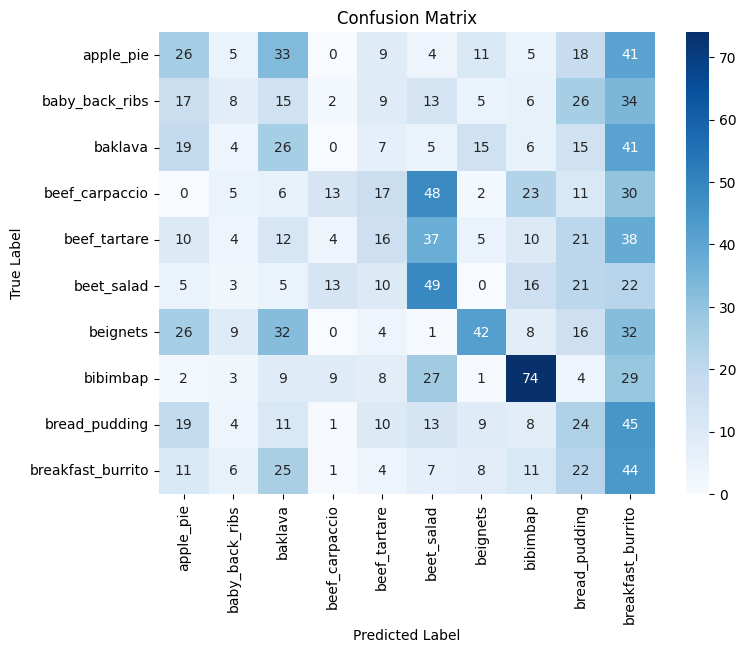

In [174]:
# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# 2. Plot confusion matrix
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualize metrics: Accuracy and loss

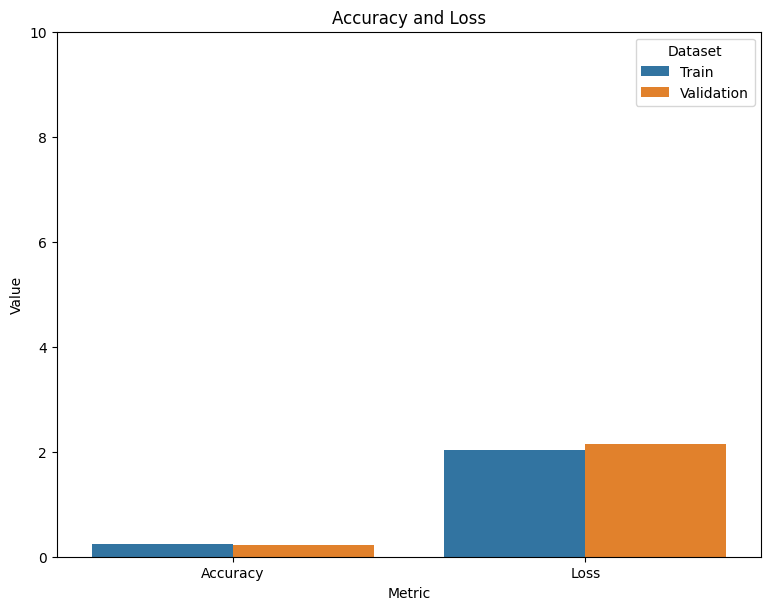

In [175]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Train': [train_accuracy, train_loss],
    'Validation': [val_accuracy, val_loss]
})
metrics_melted = pd.melt(metrics, id_vars=['Metric'], var_name='Dataset', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='Dataset', data=metrics_melted)
plt.title('Accuracy and Loss')

plt.ylim(0,10)
plt.show()

# Visualize metrics: Precision, Recall, f1-score

<Figure size 1000x600 with 0 Axes>

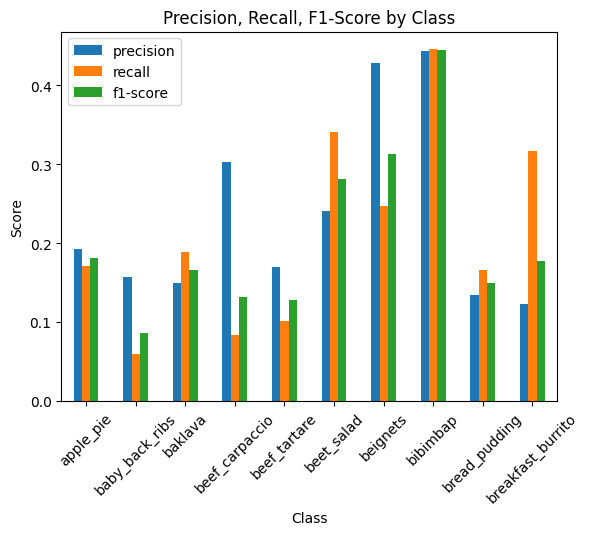

In [176]:
# 3. Plot precision, recall, f1-score
# Convert classification report to DataFrame for visualization
report_dict = classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.iloc[:-3]  # Remove support and avg rows if present

plt.figure(figsize=(10, 6))
metrics_df = report_df[['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar')
plt.title('Precision, Recall, F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# Visualize metrics: Plot runtime performance

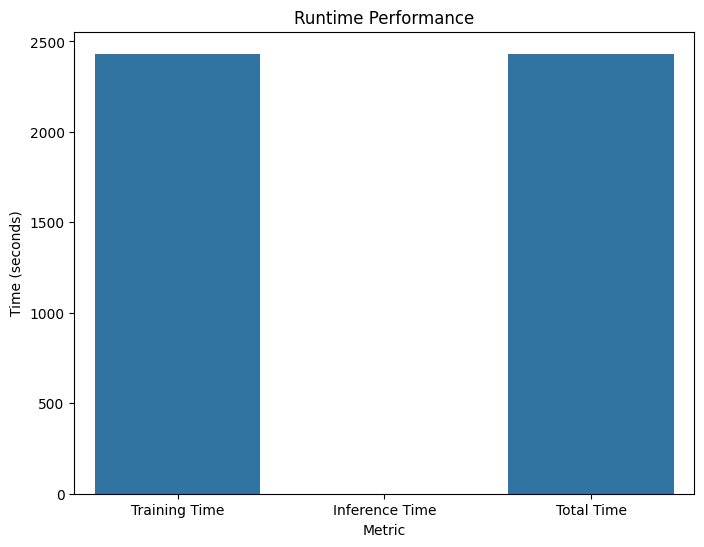

In [177]:
# 4. Plot runtime performance
# Here we show the runtime performance for training and inference
# Note: For demonstration, we use the grid search training time and a quick inference time measurement

inference_start = time.time()
_ = best_dt.predict(X_val_combined)
inference_time = time.time() - inference_start

performance = pd.DataFrame({
    'Metric': ['Training Time', 'Inference Time', 'Total Time'],
    'Time (seconds)': [train_time, inference_time, train_time + inference_time]
})
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Time (seconds)', data=performance)
plt.title('Runtime Performance')
plt.ylabel('Time (seconds)')
plt.show()

# Visualize metrics: Depth vs. Accuracy plot (to tune the model)

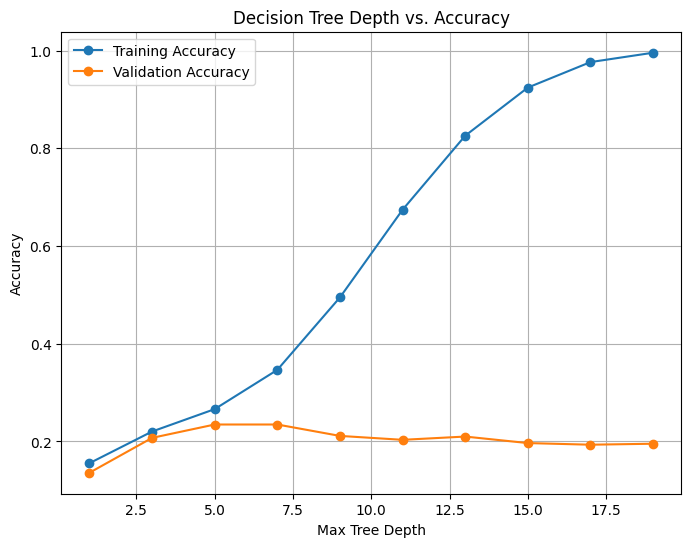

In [178]:
# 5. Depth vs. Accuracy plot (to tune the model)
# This shows how accuracy changes with tree depth
max_depths = [d for d in range(1, 21, 2)]
train_scores = []
val_scores = []

for depth in max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train_combined, y_train)
    train_scores.append(accuracy_score(y_train, dt_temp.predict(X_train_combined)))
    val_scores.append(accuracy_score(y_val, dt_temp.predict(X_val_combined)))

plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_scores, 'o-', label='Training Accuracy')
plt.plot(max_depths, val_scores, 'o-', label='Validation Accuracy')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Runtime Performance Summary

In [179]:
# Runtime performance summary
runtime_summary = {
    'Total Images': len(y_train) + len(y_val),
    'Training Time (s)': train_time,
    'Inference Time (s)': inference_time,
    'Images per Second (Training)': len(y_train) / train_time,
    'Images per Second (Inference)': len(y_val) / inference_time
}

print("\nRuntime Performance Summary:")
for key, value in runtime_summary.items():
    print(f"{key}: {value}")


Runtime Performance Summary:
Total Images: 7500
Training Time (s): 2432.390957593918
Inference Time (s): 0.0012218952178955078
Images per Second (Training): 2.4667087259422735
Images per Second (Inference): 1227601.1707317072


# WITHOUT PCA RESULTS:

# WITH PCA RESULTS (n_components = 15):
### Train Accuracy: 0.3248333333333333
###  Validation Accuracy: 0.144
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
## 1. PCA May Be Removing Important Information
## 2. PCA works best when there are strong correlations between features. Deep features (EfficientNet) and handcrafted features (HOG & Color Histogram) may not be highly correlated, causing PCA to discard useful information.
# 3.  4. EfficientNet Features Might Not Be Aligned with Decision Tree EfficientNet extracts deep abstract features, but Decision Trees work best with structured, interpretable features. The two might not complement each other well.
# 2. Decision Trees Are Inefficient for High-Dimensional Data
	# •	Decision Trees struggle with large feature spaces.
	# •	Training time increases exponentially as the number of features grows.


## Solution: Normalize & Standardize Features

# PCA TO 50: GOOD RESULTS AND HIGHEST SO FAR
# Train Accuracy: 0.2645
# Validation Accuracy: 0.24533333333333332
# Train loss: 2.0054
# Validation loss: 2.2357

# HIGHER PCA LIKE 200 DO NOT INCREASE ACCURACY

# PCA 80 OVERFITS THE MODEL SIGNIFICANTLY